# Forward Propagation Code for a Sphere


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
import copy
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
def SphericalThickness(r,x,y):
    '''
    Returns thickness through sphere of radius r at a given (x,y)
    '''
    if x**2 + y**2 < r**2:
        return np.sqrt(r**2 - (x**2 + y**2)) * 2
    else:
        return 0.


radius = 50e-3   # m
d = 250e-3       # m: camera distance
Lx = 100e-3      # m: image x-length
Ly = 100e-3      # m: image y-length
nbins_x = 101
nbins_y = 101
dx = Lx/nbins_x
dy = Ly/nbins_y

h = 6.626e-34                    # J.s: Planck's constant
c = 2.99e8                       # m/s: Speed of light
E = 9.61306e-13                  # J: incident x-ray energy
delta = 1.2743e-5                # δ for Carbon
beta = 3.8559e-8                 # β for Carbon
n = 1 - delta + 1j*beta          # Complex refractive index for Carbon
k = ( (2*np.pi)/(h*c) ) * E * n  # rad/m: Complex wave vector

# Initialize the attenuated wave
attenuated_wave = np.full((nbins_x,nbins_y), np.exp(1j * k * radius), dtype = np.complex128)

for i in range(nbins_x):
    x = (i - nbins_x/2) * dx       # maps index i to coordinate x
    for j in range(nbins_y):
        y = (j - nbins_y/2) * dy   # maps index j to coordinate y
        t = SphericalThickness(radius,x,y)
        attenuated_wave[i,j] *= np.exp(-k*t)  # multiply plane wave in each bin by attenuation factor

x = np.array([i - nbins_x/2 for i in range(nbins_x)])
y = np.array([j - nbins_y/2 for j in range(nbins_y)])

print(attenuated_wave)

# plt.hist2d(X,Y,np.abs(attenuated_wave))
# plt.show()

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [4]:
def SphericalAttenuation_pw(r, nbins_x, nbins_y):
    '''
    Inputs:
        r (float): radius
    Outputs:
        attenuated_wave (ndarray): xy grid of waveform values post-attenuation
    '''
    grid = np.zeros((nbins_x,nbins_y))
    
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            makesphere.exe
            kthxbai


In [19]:
def refract(n, r, R, l):
    '''
    Inputs:
    n (array of three elements): normal vector at incident point of light vector
    r (float): refractive index ratio
    R (float): radius of sphere
    l (array of three elements): incident light vector
    
    Returns:
    v_refract (array of three elements): refracted light vector
    '''
    c = 0-np.dot(n, l)
    temp = 1-(r**2)*(1-(c**2))
    if temp < 0:
        return -1
    A = (r*c - np.sqrt(temp))/R
    v_refract = r*np.array([0,0,1]) + A*n
    return v_refract

def get_ray(R,x,y,r, suppress=True):
    '''
    Inputs:
    R (float): radius
    x (float): x-coordinate, less than R
    y (float): y-coordinate, less than R
    r (float): refractive index ratio
    suppress (bool): Suppresses print statements
    
    Returns:
    v_refract2 (array of four elements): exiting light vector, and path length
    '''
    # Get z coordinate and entry point
    z_sq = np.square(R)-np.square(x)-np.square(y)
    if z_sq < 0:
         return np.array([0,0,1,float('inf'),x,y,0])
    z = -np.sqrt(z_sq)
    entry_point = np.array([x,y,z])
    if not suppress:
        print("The entry point is",  entry_point)
        
    # Get surface normal vector
    n_in = np.array([x/R,y/R,z/R])
    if not suppress:
        print("The normalised entry vector is", n_in)
    
    ## Get the first refraction vector
    v_refract1 = refract(n_in, r, R, np.array([0,0,1]))
    
    # if v_refract1 is erroneous, return 'inf' and the coordinate
    if type(v_refract1) == int:
        return np.array([0,0,1,float('inf'),x,y,z])
    
    # Normalize v_refract1
    v_refract1 = v_refract1/linalg.norm(v_refract1)
    if not suppress:
        print("v_refract1 is", v_refract1)
        print(linalg.norm(v_refract1))
    
    # Some analytical expression for t: the depth parameter
    t = 0 - (2*np.dot(entry_point, v_refract1))/np.dot(v_refract1, v_refract1)
    if not suppress:
        print("t is", t)
    
    # Eqn of a ray through the sphere
    exit_point = entry_point + t*v_refract1
    if not suppress:
        print("The exit point is", exit_point)
        print("The magnitude of the exit point is", exit_point[0]**2 + exit_point[1]**2 + exit_point[2]**2)
    
    # Get normal vector at exit point
    n_out = 0 - exit_point/linalg.norm(exit_point)
    if not suppress:
        print("The normalised exit vector is", n_out)
    
    # Get v_refract2
    v_refract2 = refract(n_out, 1/r, R, v_refract1)
    if type(v_refract1) == int:
        return np.array([0,0,1,float('inf'),x,y,exit_point[2]])
    v_refract2 = v_refract2/linalg.norm(v_refract2)
    
    # Append t and entry_point to v_refract2
    v_refract2 = np.append(v_refract2, t)
    v_refract2 = np.concatenate([v_refract2, exit_point])
    return v_refract2

def create_matrix(grid_params, R, r):
    '''
    grid_params (array of six elements): min_x, max_x, min_y, max_y, sampling points along x and y axes
    R (float): Radius of sphere
    r (float): refractive index ratio
    '''
    min_x, max_x, min_y, max_y, points_x, points_y = grid_params
    data = np.zeros((7,points_x,points_y))
    x_axis = np.linspace(min_x, max_x, points_x)
    y_axis = np.linspace(min_y, max_y, points_y)
    for i in range(points_x):
        for j in range(points_y):
            ans = get_ray(R,x_axis[i],y_axis[j],r)
            for k in range(7):
                data[k][i][j] = ans[k]
    return data

def screen(intensity, matrix, distance, beta, R, grid_params):
    '''
    grid_params (array of six elements): same as above
    intensity (float): intensity of light ray after attenuation
    matrix (3d matrix): Matrix of light vector + path length for each x, y
    distance (float): distance to screen
    '''
    data2 = copy.deepcopy(data)
    min_x, max_x, min_y, max_y, points_x, points_y = grid_params

    # Attenuate light
    data2[3][:][:] = np.exp((-beta)*data2[3][:][:])
    
    # Calculate distance in z-direction of each ray from screen
    distance_from_screen = distance + R - data[6][:][:]
 
    # Find x and y distances travelled by each ray from individual exit point to screen
    data2[0][:][:] = data2[4][:][:] + distance_from_screen*np.divide(data2[0][:][:], data2[2][:][:])
    data2[1][:][:] = data2[5][:][:] + distance_from_screen*np.divide(data2[1][:][:], data2[2][:][:])
    data2[2][:][:] = 1
    
    # Find x and y distances travelled by each ray from individual exit point to screen
    #data2[0][:][:] = data2[4][:][:] + distance*np.divide(data2[0][:][:], data2[2][:][:])
    #data2[1][:][:] = data2[5][:][:] + distance*np.divide(data2[1][:][:], data2[2][:][:])
    #data2[2][:][:] = 1
    
    # Add in light that is not blocked by sphere
    x_axis = np.linspace(min_x, max_x, points_x)
    y_axis = np.linspace(min_y,  max_y, points_y)
    for i in range(data2.shape[1]):
        for j in range(data2.shape[2]):
            dist_check = (x_axis[i])**2 + (y_axis[j])**2
            if dist_check > R**2:
                data2[3][i][j] += 1
    return data2

def plot_intensity(data2, grid_params):
    '''
    data2 (3d matrix): data matrix
    grid_params (array of six elements): same as above
    '''
    X = data2[0][:][:]
    Y = data2[1][:][:]
    Z = data2[3][:][:]

    fig = plt.figure(figsize=(6,5))
    plt.pcolor(X,Y,Z, cmap='coolwarm')
    plt.colorbar()

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z)


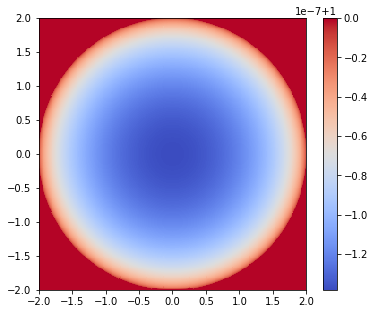

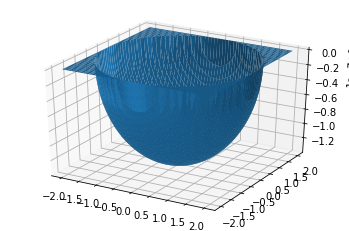

In [20]:
# Run code

E = 5928.44775 # eV


sampling_params = [-2, 2, -2, 2, 300, 300]
R = 2
# r = 1.03
# beta = 2
intensity = 1
distance = 1

# n-Heptane values
delta = 1.51026588E-05
beta  = 3.45463604E-08
r     = 1.000015

# data = create_matrix(sampling_params, R, r)
# data2 = screen(intensity, data, distance, beta, R, sampling_params)
plot_intensity(data2, sampling_params)

# np.savetxt("foo.csv", data2[0][:][:], delimiter=",")
# np.savetxt("bar.csv", data2[1][:][:], delimiter=",")
# np.savetxt("now.csv", data2[3][:][:], delimiter=",")